<a href="https://colab.research.google.com/github/blitztarun/PROJECTS/blob/main/CV03_AnomalyDetection_f_AnoGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection

En este ejemplo se usa la famosa base de datos [MNIST](https://en.wikipedia.org/wiki/MNIST_database) que tiene en letra manuscrita los 10 dígitos (0,1,...9). Se entrena el modelo para que el '0' sea la clase "normal", y todo el resto de dígitos sea considerado como "anomalía".

Implementacion basada en [f-AnoGan](http://github.com/dbbbbm/f-AnoGAN-PyTorch)

Esta umplementación ocupa como entrada imágenes de 3 canales de color de 64x64 pixeles. En caso de querer usar otras imágenes cambiar la función one_class_dataloader en F-AnoGan. En caso de querer usar otra dimensión de imágenes debería funcionar cambiando DIM y OUTpUT_DIM en WGAN 64x64.

Adaptación hecha por Joaquín Hofmann y Domingo Mery

Referencia:
Schlegl, T., Seeböck, P., Waldstein, S. M., Langs, G., & Schmidt-Erfurth, U. (2019). [f-AnoGAN: Fast unsupervised anomaly detection with generative adversarial networks](https://www.sciencedirect.com/science/article/abs/pii/S1361841518302640). Medical image analysis, 54, 30-44.

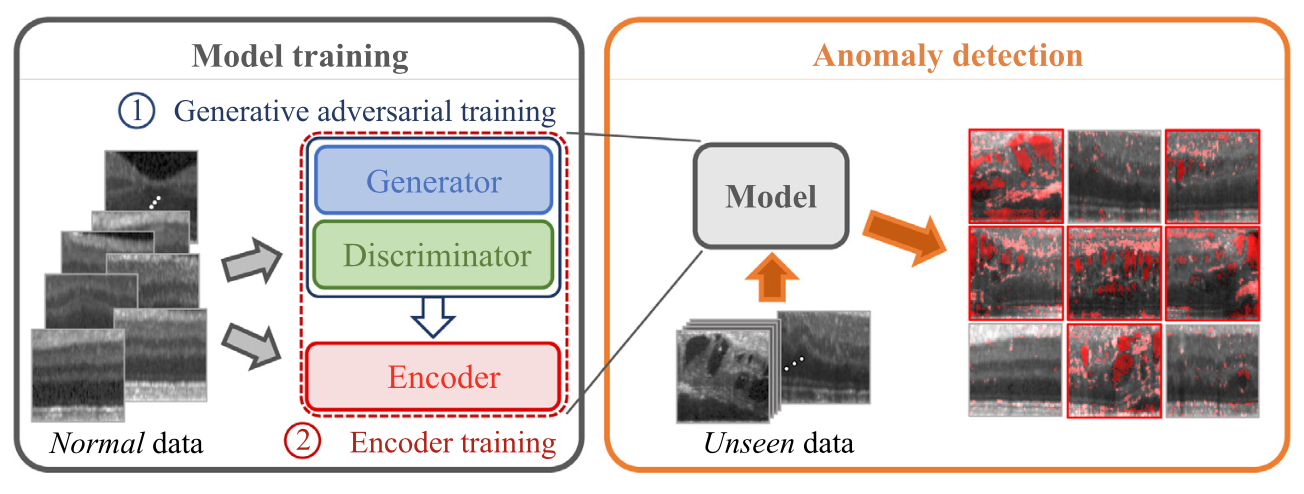

# Some functions

In [ ]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

# WGAN 64x64

In [ ]:
# wgan64x64.py
from torch import nn
from torch.autograd import grad
import torch
DIM = 64
OUTPUT_DIM = 3*64*64


class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output


class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == None:
            # TODO: ????
            self.bn1 = nn.BatchNorm2d(output_dim)
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output


class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output


class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output


class GoodGenerator(nn.Module):
    def __init__(self, dim=DIM, output_dim=OUTPUT_DIM):
        super(GoodGenerator, self).__init__()

        self.dim = dim

        self.ln1 = nn.Linear(128, 4*4*8*self.dim)
        self.rb1 = ResidualBlock(8*self.dim, 8*self.dim, 3, resample='up')
        self.rb2 = ResidualBlock(8*self.dim, 4*self.dim, 3, resample='up')
        self.rb3 = ResidualBlock(4*self.dim, 2*self.dim, 3, resample='up')
        self.rb4 = ResidualBlock(2*self.dim, 1*self.dim, 3, resample='up')
        self.bn = nn.BatchNorm2d(self.dim)

        self.conv1 = MyConvo2d(1*self.dim, 3, 3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        output = self.ln1(input.contiguous())
        output = output.view(-1, 8*self.dim, 4, 4)
        output = self.rb1(output)
        output = self.rb2(output)
        output = self.rb3(output)
        output = self.rb4(output)

        output = self.bn(output)
        output = self.relu(output)
        output = self.conv1(output)
        output = self.tanh(output)
        # output = output.view(-1, OUTPUT_DIM)
        return output




class GoodDiscriminator(nn.Module):
    def __init__(self, dim=DIM):
        super(GoodDiscriminator, self).__init__()

        self.dim = dim

        self.conv1 = MyConvo2d(3, self.dim, 3, he_init=False)
        self.rb1 = ResidualBlock(self.dim, 2*self.dim,
                                 3, resample='down', hw=DIM)
        self.rb2 = ResidualBlock(
            2*self.dim, 4*self.dim, 3, resample='down', hw=int(DIM/2))
        self.rb3 = ResidualBlock(
            4*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/4))
        self.rb4 = ResidualBlock(
            8*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/8))
        self.ln1 = nn.Linear(4*4*8*self.dim, 1)
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def extract_feature(self, input):
        output = input.contiguous()
        output = output.view(-1, 3, DIM, DIM)
        output = self.conv1(output)
        output = self.rb1(output)
        output = self.rb2(output)
        output = self.rb3(output)
        output = self.rb4(output)
        output = output.view(-1, 4*4*8*self.dim)
        return output

    def forward(self, input):
        output = self.extract_feature(input)
        output = self.ln1(output)
        output = output.view(-1)
        return output





class Encoder(nn.Module):
    def __init__(self, dim, output_dim, drop_rate=0.0):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(drop_rate)
        self.conv_in = nn.Conv2d(3, dim, 3, 1, padding=1)
        self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 64)
        self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 32)
        self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 16)
        self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 8)
        self.fc = nn.Linear(4*4*8*dim, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        x = self.conv_in(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.tanh(x)





# F-AnoGan

In [ ]:
from torch.utils.data import DataLoader
from torch import optim
from torch import autograd
from torch import nn
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import sampler
from argparse import ArgumentParser
#from wgan64x64 import *
from sklearn import metrics
import torch
from tqdm.auto import tqdm
import numpy as np
import time
import os
import sys
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
sys.path.append(os.getcwd())



MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp
DIM = 64  # This overfits substantially; you're probably better off with 64
LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = 30  # Batch size
OUTPUT_DIM = 3*64*64  # Number of pixels in image (3*64*64)
NOISE_SIZE = 128
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False


def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(
        real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 3, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty



def one_class_dataloader(c, nw=0, bs=64):
    transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])
    mnist = datasets.MNIST('./', download=True,
                             train=True, transform=transform)
    labels = np.array(mnist.targets)
    class_indices = np.argwhere(labels == c)
    class_indices = class_indices.reshape(class_indices.shape[0])
    trainloader = DataLoader(
        mnist, bs, sampler=sampler.SubsetRandomSampler(class_indices),
        num_workers=nw, pin_memory=True, drop_last=True)
    test = datasets.MNIST('./',train=False, download=False, transform=transform)
    testloader = DataLoader(test, bs*2, num_workers=nw, pin_memory=True)

    return trainloader, testloader


def wgan_training(PreTrained=False,saveat=1000,genstart=0):
    netG = GoodGenerator().to(device)
    netD = GoodDiscriminator().to(device)
    if PreTrained:
      print('loading pretrained discriminator-weights '+D_Model+'...')
      netD.load_state_dict(torch.load(D_Model))
      print('loading pretrained generator-weights '+G_Model+'...')
      netG.load_state_dict(torch.load(G_Model))

    #one = torch.FloatTensor([1]).to(device)
    one = torch.tensor(1, dtype=torch.float).to(device)
    mone = one * -1

    optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.9))

    dataloader, _ = one_class_dataloader(options_c, 2, BATCH_SIZE)
    D_real_list = []
    D_fake_list = []
    D_cost_list = []
    G_cost_list = []
    for iteration in tqdm(range(1+genstart, WGAN_ITERS + 1)):
        #print('WGAN - Iteration:'+str(iteration))
        start_time = time.time()
        ############################
        # (1) Update D network
        ###########################
        for i, (_data, _) in enumerate(dataloader):
            if i == CRITIC_ITERS:
                break
            netD.zero_grad()

            # train with real

            real_data = _data.to(device)



            D_real = netD(real_data)
            D_real = D_real.mean()
            D_real.backward(mone)
            D_real_list.append(D_real.item())

            # train with fake
            noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
            noise = noise.to(device)
            fake = netG(noise).detach()
            inputv = fake
            D_fake = netD(inputv)
            D_fake = D_fake.mean()
            D_fake.backward(one)
            D_fake_list.append(D_fake.item())

            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, real_data.data, fake.data)
            gradient_penalty.backward()

            # print "gradien_penalty: ", gradient_penalty

            D_cost = D_fake - D_real + gradient_penalty
            D_cost_list.append(D_cost.item())
            Wasserstein_D = D_real - D_fake
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()

        noise = torch.randn(BATCH_SIZE, 128)
        noise = noise.to(device)
        fake = netG(noise)
        G = netD(fake)
        G = G.mean()
        G.backward(mone)
        G_cost = -G
        optimizerG.step()
        G_cost_list.append(G_cost.item())

        # Write logs and save samples
        if iteration % saveat == 0:
            save_image(fake*0.5+0.5, 'wgangp/fake_' + num2fixstr(iteration,5) + '.jpg')
            print('Iters:{}, D(real):{}, D(fake):{}, Loss D:{}, Loss G:{}'.format(
                iteration,
                np.mean(D_real_list),
                np.mean(D_fake_list),
                np.mean(D_cost_list),
                np.mean(G_cost_list),)
            )
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netD.state_dict(), 'models/netD_' + num2fixstr(iteration,5) + '.pth')
            torch.save(netG.state_dict(), 'models/netG_' + num2fixstr(iteration,5) + '.pth')


def train_encoder(PreTrained=False,saveat=100,genstart=0):
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False

    dataloader, _ = one_class_dataloader(options_c, 2, BATCH_SIZE)

    netE = Encoder(DIM, NOISE_SIZE).to(device)
    if PreTrained:
      netE.load_state_dict(torch.load(E_Model))

    optimizer = optim.Adam(netE.parameters(), 1e-4, (0.0, 0.9))

    crit = nn.MSELoss()

    for iteration in tqdm(range(1+genstart, ENCODER_ITERS+1)):
        losses = []
        netE.train()
        for (x, _) in dataloader:
            x = x.to(device)
            code = netE(x)
            rec_image = netG(code)
            d_input = torch.cat((x, rec_image), dim=0)
            f_x, f_gx = netD.extract_feature(d_input).chunk(2, 0)
            loss = crit(rec_image, x) + options_alpha * crit(f_gx, f_x.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(iteration, np.mean(losses))
        netE.eval()
        rec_image = netG(netE(x))
        d_input = torch.cat((x, rec_image), dim=0)

        if iteration % saveat == 0:
            save_image(d_input*0.5+0.5, 'rec/rec_'+num2fixstr(iteration,4)+'.png')
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netE.state_dict(), 'models/netE_' + num2fixstr(iteration,5) + '.pth')
    torch.save(netE.state_dict(), 'models/netE.pth')


def evaluate():
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))
    netD.eval()
    netE = Encoder(DIM, NOISE_SIZE).to(device)
    netE.load_state_dict(torch.load(E_Model))
    netE.eval()

    _, dataloader = one_class_dataloader(options_c, 0, BATCH_SIZE)
    # crit = nn.MSELoss()
    y_true, y_score = [], []
    in_real, out_real, in_rec, out_rec = [], [], [], []
    with torch.no_grad():
        for (x, label) in tqdm(dataloader):
            bs            = x.size(0)
            x             = x.to(device)
            rec_image     = netG(netE(x))
            d_input       = torch.cat((x, rec_image), dim=0)
            idx           = (label == options_c)
            in_real.append(x[idx])
            in_rec.append(rec_image[idx])
            idx           = (label != options_c)
            out_real.append(x[idx])
            out_rec.append(rec_image[idx])
            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
            x0            = x.view(x.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM])
            rec_diff      = (x1 - x0)**2
            rec_score     = rec_diff.mean(dim=1)
            feat_diff     = ((f_x - f_gx)**2)
            feat_score    = feat_diff.mean(dim=1)
            outlier_score = rec_score + options_alpha * feat_score
            y_true.append(label)
            y_score.append(outlier_score.cpu())
    in_real = torch.cat(in_real, dim=0)[:32]
    in_rec = torch.cat(in_rec, dim=0)[:32]
    out_real = torch.cat(out_real, dim=0)[:32]
    out_rec = torch.cat(out_rec, dim=0)[:32]
    save_image(torch.cat((in_real, in_rec), dim=0), 'real.png', normalize=True)
    save_image(torch.cat((out_real, out_rec), dim=0),
               'fake.png', normalize=True)
    y_score = np.concatenate(y_score)
    y_true = np.concatenate(y_true)
    y_true[y_true != options_c] = -1
    y_true[y_true == options_c] = 1
    print('AUC = ', metrics.roc_auc_score(y_true, -y_score))
    plt.figure()
    plt.hist(y_score[y_true==1], 100, density=True, alpha=0.5, color='blue')
    plt.hist(y_score[y_true==-1], 100, density=True, alpha=0.5, color='red')
    plt.show()

# Initial Settings

In [ ]:
!mkdir wgangp
!mkdir rec
!mkdir models

In [ ]:
options_c     = 0 # <- normal class
options_alpha = 1
options_cuda  = '0'
device = torch.device('cuda:{}'.format(options_cuda))
torch.cuda.set_device('cuda:{}'.format(options_cuda))

# Training WGAN

In [ ]:
genstart   = 0 # generación de partida (en caso de existir entrenamiento previo)
G_Model    = 'models/netG_' + num2fixstr(genstart,5) + '.pth'
D_Model    = 'models/netD_' + num2fixstr(genstart,5) + '.pth'

saveat     = 50   # cada cuantas iteraciones se guarda modelo
WGAN_ITERS = 100  # iteraciones máximas del entrenamiento

pretrained = genstart>0
wgan_training(PreTrained=pretrained,saveat=saveat,genstart=genstart)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/100 [00:00<?, ?it/s]

Iters:50, D(real):52.54341165739298, D(fake):-63.107315638542175, Loss D:-79.00308942413331, Loss G:68.72924690246582
Iters:100, D(real):27.847916126579047, D(fake):-49.30165619447828, Loss D:-53.72701587581634, Loss G:52.46301226139069


# Training Encoder-Decoder

In [ ]:
encstart      = 0
ENCODER_ITERS = 20
saveat        = 10 # cada cuantas iteraciones se guarda modelo

gen           = WGAN_ITERS #generación del generator a usar
G_Model       = 'models/netG_' + num2fixstr(gen,5) + '.pth'
D_Model       = 'models/netD_' + num2fixstr(gen,5) + '.pth'
E_Model       = 'models/netE_' + num2fixstr(encstart,5) + '.pth'

pretrained    = encstart>0

train_encoder(PreTrained=pretrained,saveat=saveat)

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8583455473033305
2 0.3951572606406236
3 0.3330152658792922
4 0.30090902806236053
5 0.28165499162552926
6 0.2650843540272737
7 0.2551168416659844
8 0.24602218766502923
9 0.23873549268632976
10 0.2324583927538189
11 0.22756895725497134
12 0.22326581195223755
13 0.21874434814840404
14 0.21468234137835238
15 0.21138441479448133
16 0.20898170625497847
17 0.20632324991795012
18 0.20365973195146184
19 0.2012804519706571
20 0.19931361638955053


# Evaluation

  0%|          | 0/167 [00:00<?, ?it/s]

AUC =  0.9975078057830671


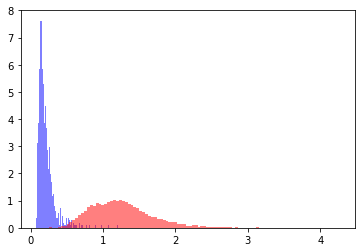

In [ ]:
Ggen    = WGAN_ITERS #generación del generator a usar del generator
Egen    = ENCODER_ITERS #generación a usar del Encoder

G_Model = 'models/netG_' + num2fixstr(Ggen,5) + '.pth'
D_Model = 'models/netD_' + num2fixstr(Ggen,5) + '.pth'
E_Model = 'models/netE.pth'

evaluate()
